# VGG16 Model Transfer Learning

# Dependency

In [1]:
import os
from os import listdir, makedirs
from os.path import join, exists, expanduser

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D, Lambda
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


# Data and model path config

## Load data

In [2]:
# dimensions of our images.
img_width, img_height = 224, 224

In [3]:
train_data_dir = './fruits-360/Training/'
test_data_dir = './fruits-360/Test/'
batch_size = 16

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1. / 255)


In [6]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


## Load Model

In [16]:
vgg16_base = applications.VGG16(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = vgg16_base.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = Dense(131, activation='softmax')(x)
new_model = Model(inputs=vgg16_base.input, outputs=predictions)


# Compiling & Training the Model

In [17]:
new_model.compile(optimizer=optimizers.Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [24]:
for layer in new_model.layers[:-2]:
    layer.trainable = False
new_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [ ]:
with tf.device("/device:GPU:0"):
    history_pretrained = new_model.fit_generator(
    train_generator,
    epochs=5,
    verbose = 1,
    validation_data = validation_generator,)
    
    

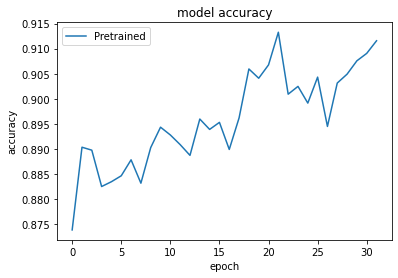

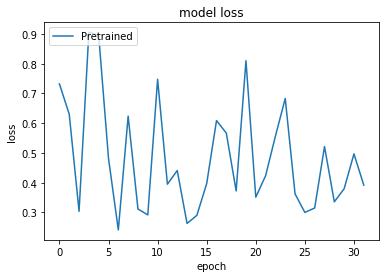

In [93]:

import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Pretrained'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Pretrained'], loc='upper left')
plt.show()

# Test model on test dataset

In [ ]:
history_pretrained_eval = new_model.evaluate_generator(generator=test_generator,verbose = 1)

In [95]:
for name,value in zip(model.metrics_names, history_pretrained_eval):
    print(f"{name}: {value}")

loss: 0.34994614124298096
accuracy: 0.8520362973213196


In [96]:
model.save("VGG16_2extraUnfreeze.h5")